In [1]:
from pathlib import Path
import sys

# More reliable: get the project root from the notebook's location
ROOT_PATH = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
# Or even better for notebooks:
ROOT_PATH = Path().resolve().parent  # Goes up from notebooks/ folder

sys.path.append(str(ROOT_PATH))

from src.data.dataset import OrionAEFrameDataset, CWTScalogramDataset

In [3]:
cwt = CWTScalogramDataset(
    data_path=r'/home/serene/orion-ae-study/data/processed/example_1_features_20251222_183540',
    config_path=r'/home/serene/orion-ae-study/configs/dataset/cwt_scalogram_B_e.yaml',
    type='all'
)

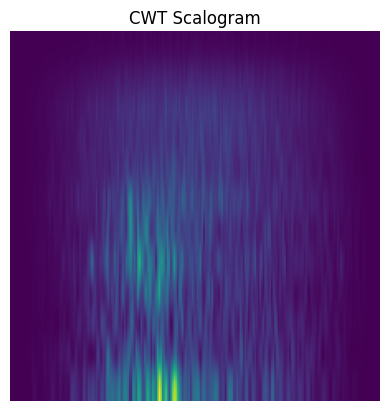

In [4]:
import matplotlib.pyplot as plt
import numpy as np

cwt_image = cwt[11000]['final']

# Convert from CHW (3, H, W) to HWC (H, W, 3) format for matplotlib
if isinstance(cwt_image, np.ndarray) and cwt_image.ndim == 3:
    # Transpose from (C, H, W) to (H, W, C)
    cwt_image = np.transpose(cwt_image, (1, 2, 0))

# Normalize/clip values for display (assuming values might be outside [0, 1] or [0, 255])
if cwt_image.dtype != np.uint8:
    # If values are in [0, 1] range, scale to [0, 255]
    if cwt_image.max() <= 1.0:
        cwt_image = (cwt_image * 255).astype(np.uint8)
    else:
        # Clip to valid range and convert to uint8
        cwt_image = np.clip(cwt_image, 0, 255).astype(np.uint8)

plt.imshow(cwt_image)
plt.title("CWT Scalogram")
plt.axis('off')
plt.show()

In [5]:
import numpy as np

# Initialize with zero arrays of shape (3, 224, 224) for each label
avg_cwt = [np.zeros((3, 224, 224)) for _ in range(7)]
cwt_count = [0 for _ in range(7)]
target_serie = 'B'

for data in cwt:
    if data['serie'] == target_serie:
        label = data['label']
        avg_cwt[label] += data['final']  # Accumulate the image
        cwt_count[label] += 1

# Compute average by dividing accumulated sum by count
avg_cwt = [avg_cwt[i] / cwt_count[i] if cwt_count[i] > 0 else None 
           for i in range(7)]

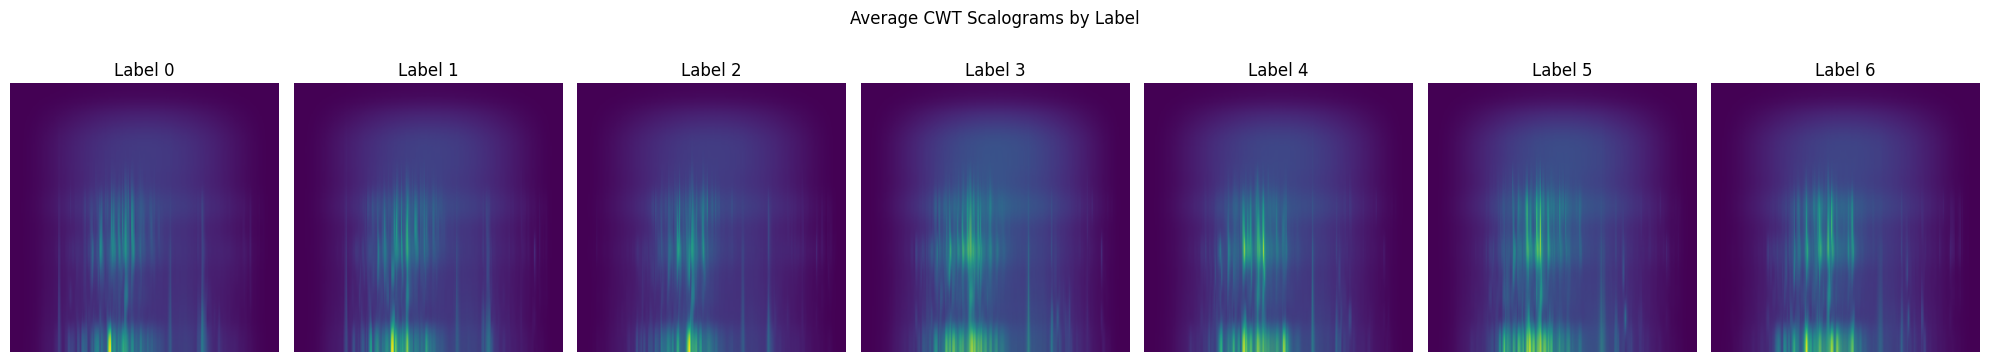

In [6]:
import matplotlib.pyplot as plt

# For label 0, for example:
avg_image_hwc = np.transpose(avg_cwt[2], (1, 2, 0))  # (3, 224, 224) -> (224, 224, 3)

# Plot all images from avg_cwt together (avg_cwt contains the per-label images)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 7, figsize=(20, 4))
for i, avg_img in enumerate(avg_cwt):
    ax = axes[i]
    if avg_img is not None:
        # Convert from (3, 224, 224) to (224, 224, 3)
        img_disp = np.transpose(avg_img, (1, 2, 0))
        # Normalize/clamp for display
        if img_disp.dtype != np.uint8:
            if img_disp.max() <= 1.0:
                img_disp = (img_disp * 255).astype(np.uint8)
            else:
                img_disp = np.clip(img_disp, 0, 255).astype(np.uint8)
        ax.imshow(img_disp)
        ax.set_title(f"Label {i}")
    else:
        ax.axis('off')
        ax.set_title(f"Label {i}\n(No samples)")
    ax.axis('off')
plt.suptitle("Average CWT Scalograms by Label")
plt.tight_layout()
plt.show()
